# Assigment 5

## Upload your code (.ipynb) on Learn dropbox and submit pdfs of the code and to Crowdmark.

## -----------------------------------------------------------------------------------------------------------

## Classification

Download the dataset 
    news20.binary dataset: https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary.html#news20.binary
Check Assignment 4 for instructions about loading this dataset.

Question 1
-------------

Solve the l1-regularized logistic regression problem
$$\mbox{minimize}_{x\in\mathbb{R}^d,\beta\in\mathbb{R}} \ \lambda \|x\|_1 + \frac{1}{n} \sum_{i=1}^n \log (1+ \exp(-b_i(a_i^Tx + \beta)))$$
using 

1) Proximal gradient descent

2) Accelerated proximal gradient descent

3) Proximal coordinate descent

4) Accelerated proximal coordinate descent

Tune the model parameter $\lambda$ and any parameters that the algorithms have. You only have to tune $\lambda$ once and use the same $\lambda$ for all algorithms. Use similar techniques to Assignment 4 to tune $\lambda$. Plot the objective function (y-axis) vs running time in sec (x-axis) for all algorithms in the same plot. Make sure that the plots are clean and use appropriate legends. Report your generalization error. This should be measured in the same way as Assignment 4.

For training split the data into training (the first 15996 datapoints), validation (the next 2000 datapoints) and testing (the next 2000 datapoints). Do not use the testing data to influence training in any way. This means that you should compute the generalization error only once when you finish your work with this part of the assignment.

Marks: 15

Question 2
-------------

Pick one algorithm that you want and plot the number of nonzeros in the output of the algorithm against $\lambda$. Explain in a couple of sentences (or less) what do you observe.

Marks: 10

In [1]:
# Download the LIBSVM package from here: https://www.csie.ntu.edu.tw/~cjlin/libsvm/#download 
# If your download is successfull you should have the folder with name: libsvm-3.24.
# We will use this package to load datasets. 

# Enter the downloaded folder libsvm-3.24 through your terminal. 
# Run make command to compile the package.

# Load this auxiliary package.
import sys

# add here your path to the folder libsvm-3.24/python
path = "/Users/michaelhuang/Documents/school/2019fall/cs794/a45/libsvm-3.24/python/"
# Add the path to the Python paths so Python can find the module.
sys.path.append(path)

# Load the LIBSVM module.
from svmutil import *

# Add here your path to the folder libsvm-3.24
path = "/Users/michaelhuang/Documents/school/2019fall/cs794/a45/libsvm-3.24/"

import matplotlib.pyplot as plt

# Numpy is useful for handling arrays and matrices.
import numpy as np
import time
from scipy.sparse import csr_matrix
from scipy import sparse
import sklearn.feature_extraction
from scipy.sparse import hstack
from sklearn.model_selection import train_test_split
import random
from numpy.linalg import norm
import math
np.set_printoptions(threshold=np.inf)

In [690]:
path = "/Users/michaelhuang/Documents/school/2019fall/cs794/a45/news20.binary"
train_label_news, train_data_news = svm_read_problem(path)

v = sklearn.feature_extraction.DictVectorizer(sparse=True, dtype=float)
train_data_news = v.fit_transform(train_data_news)
train_label_news = np.array([train_label_news]).T

# add a column of 1
n = train_data_news.shape[0]
ones = np.ones((n,1))
train_data_news = hstack([ones, train_data_news]).tocsr()
numberOfFeature = train_data_news.shape[1]


trainA, validationA, trainLabel, validationLabel = train_test_split(train_data_news, train_label_news, test_size=0.2)

validationA, testA, validationLabel, testLabel = train_test_split(validationA, validationLabel, test_size=0.5)

def genWeight_set():
#     weights = np.ones(train_data_news.shape[1])
#     weights = np.reshape(weights,(len(weights),1))

    weights = np.random.normal(0.0,1.0,[train_data_news.shape[1],1])/train_data_news.shape[1]
#     weights = np.random.normal(0.0,1.0,[train_data_news.shape[1],1])
    return weights

In [766]:
def gradient_fx(x,b,a):
    n = b.shape[0]
    result = ((1/n)*np.sum(a.multiply(-b/(1+np.exp(b*a.dot(x)))),axis = 0)).T
    result = np.array(result)
    return result

def proximal(u, alpha, lambda_):
    condition = alpha*lambda_
    result = np.where(u>=condition, u - condition, u)
    result = np.where(np.absolute(u)<=condition, 0, result)
    result = np.where(u<=-condition, u + condition, result)
    return result

def fx(x,b,a):
    n = b.shape[0]
    result = (1/n)*np.sum(np.log(1+np.exp(-b*a.dot(x))))
    return result

def gx(x,lambda_):
    return lambda_*norm(x,1)

def armijo_line_search(xk, lambda_, b, a):
    alpha = 1
    theta = 0.5
    fxk = fx(xk, b, a)
    F_xk = fxk + gx(xk,lambda_)
    l_xk = F_xk
    grad_fx = gradient_fx(xk,b,a)
    iteration = 1
    while True:
        u = xk - alpha * grad_fx
        x_alpha = proximal(u, alpha, lambda_)
        F_xalpha = fx(x_alpha, b, a) + gx(x_alpha,lambda_)
        l_xalpha = gx(x_alpha,lambda_) + fxk + (grad_fx.T).dot(x_alpha - xk)
        if F_xalpha <= F_xk - theta*(l_xk - l_xalpha):break
        alpha = alpha/2
        iteration += 1
    return x_alpha,F_xalpha, alpha

def prox_gradient_descent(x, lambda_, b, a, epsilon, max_iterations):
    iteration = 1
    fx_array = []
    start_time = time.time()
    time_array = []
    while True:
        x_alpha,F_xalpha, alpha = armijo_line_search(x, lambda_, b, a)
        G_x = (1/alpha) * (x - x_alpha)
        fx_array.append(F_xalpha)
        time_array.append(time.time() - start_time)
        x = x_alpha
        if norm(G_x,2) <= epsilon or iteration >= max_iterations: break
        iteration += 1
    print(iteration)
    return x,fx_array,time_array

def validation(weights,validationLabel,validationA_matrix):
    prediction = 1/(np.exp(-validationA_matrix*weights)+1)
    prediction = np.where(prediction > 0.5, 1,-1)
    error = np.sum(abs(prediction - validationLabel))
    error = error/len(prediction)
    error = error/2
    return prediction,error

In [767]:
lambda_=0.0001
max_iterations = 1000
epsilon = 1.0e-2

In [768]:
weight = genWeight_set()
x_alpha, fx_array, time_array = prox_gradient_descent(weight, lambda_, trainLabel, trainA, epsilon, max_iterations)
prediction, error = validation(x_alpha,validationLabel,validationA)
print(error)

553
0.204


In [695]:
prediction, error = validation(x_alpha,testLabel,testA)
print(error)

0.2145


In [679]:
def acc_prox_grad(x, lambda_, b, a, epsilon, max_iterations):
    iteration = 1
    fx_array = []
    start_time = time.time()
    time_array = []
    y = x
    t = 1
    t_prev = t
    
    iteration = 1
    
    while True:
        x_alpha,F_xalpha, alpha = armijo_line_search(y, lambda_, b, a)
        G_y = (1/alpha) * (y - x_alpha)
        t = (1 + (1+4*(t**2))**(0.5))/2
        y = x_alpha + ((t_prev-1)/t)*(x_alpha - x)
        t_prev = t
        fx_array.append(F_xalpha)
        time_array.append(time.time() - start_time)
        x = x_alpha
        if norm(G_y,2) <= epsilon or iteration >= max_iterations: break
        iteration += 1
    print(iteration)
        
    return x,fx_array,time_array

In [696]:
weight = genWeight_set()
x_alpha_acc, fx_array_acc, time_array_acc = acc_prox_grad(weight, lambda_, trainLabel, trainA, epsilon, max_iterations)
prediction, error = validation(x_alpha_acc,validationLabel,validationA)
print(error)

61
0.211


In [697]:
prediction, error = validation(x_alpha_acc,testLabel,testA)
print(error)

0.2195


In [745]:
def partDeriv_fx(x, A, b, feature_indices):
    pd = (1/b.shape[0] * np.sum(A[:,feature_indices].multiply((-b/(np.exp(b * A.dot(x)) + 1))), axis = 0)).T
    return pd
def cood_armijo_line_search(xk, lambda_, b, a, feature_indices):
    alpha = 800
    theta = 0.5
    fxk = fx(xk, b, a)
    F_xk = fxk + gx(xk,lambda_)
    l_xk = fxk + lambda_*norm(xk[feature_indices],1)
    grad_fx = partDeriv_fx(xk, a, b, feature_indices)
    iteration = 1
    x_new = xk
    xk_partial = xk[feature_indices]
    while True:
        u = xk_partial - alpha * grad_fx
        x_alpha = proximal(u, alpha, lambda_)
        x_new[feature_indices] = x_alpha
        F_xalpha = fx(x_new, b, a) + gx(x_new,lambda_)
        l_xalpha = lambda_*norm(x_alpha,1) + fxk + (grad_fx.T).dot(x_alpha - xk_partial)
        if F_xalpha <= F_xk - theta*(l_xk - l_xalpha):break
        alpha = alpha/2
        iteration += 1
    return x_new,F_xalpha, alpha

def prox_cood_descent(x, lambda_, b, a, epsilon, max_iterations):
    fx_array = [fx(x, b, a) + gx(x,lambda_)]
    
    start_time = time.time()
    time_array = [0]
    
    block_size = 10
    num_block = math.ceil(len(x)/block_size)
    iteration = 1
    x_alpha = x
    while True:
        for i in range(num_block):
            if(i<num_block-1):
                indics = np.array(range(i*block_size,(i+1)*block_size))
            else:
                indics = np.array(range(i*block_size,len(x)))
            x_alpha,F_xalpha, alpha = cood_armijo_line_search(x_alpha, lambda_, b, a, indics)
            fx_array.append(F_xalpha)
#             print(F_xalpha)
            time_array.append(time.time() - start_time)
#             G_x = (1/alpha) * (x - x_alpha)
#             if norm(G_x,2) <= epsilon: break
            if i > max_iterations:break
            
            
        G_x = (1/alpha) * (x - x_alpha)
#         fx_array.append(F_xalpha)
#         print(F_xalpha)
#         time_array.append(time.time() - start_time)
        x = x_alpha
        if norm(G_x,2) <= epsilon or iteration >= max_iterations: break
        iteration += 1
    
    return x,fx_array,time_array
        


In [746]:
weight = genWeight_set()
x_alpha_cood, fx_array_cood, time_array_cood = prox_cood_descent(weight, lambda_, trainLabel, trainA, epsilon, max_iterations)
prediction, error = validation(x_alpha_cood,validationLabel,validationA)
print(error)

0.2435


In [731]:
def acc_cood_descent(z, lambda_, b, a, epsilon, max_iterations, li):
    u = np.zeros(z.shape)
    n = b.shape[0]
    theta = 1/n
    iteration = 1
    fx_array = [fx(z, b, a) + gx(z,lambda_)]
    start_time = time.time()
    time_array = [0]
    while iteration < max_iterations:
        i = random.randint(0,a.shape[1]-1)
        x = (theta**2)*u + z
        gradient_fx = partDeriv_fx(x, a, b, i)
        if (-1/(n*theta*li))*(gradient_fx + lambda_) > -z[i]:
            t = (-1/(n*theta*li))*(gradient_fx + lambda_)
        elif (-1/(n*theta*li))*(gradient_fx - lambda_) < -z[i]:
            t = (-1/(n*theta*li))*(gradient_fx - lambda_)
        else:
            t = -z[i]
        z[i] = z[i] + t
        u[i] = u[i] - (1-n*theta)*t/(theta**2)
        theta = ((theta**4 + 4*(theta**2))**(0.5) - theta**2)/2
        time_array.append(time.time() - start_time)
        fx_array.append(fx(z, b, a) + gx(z,lambda_))
        iteration += 1 
        print(fx_array[-1])
    return z,fx_array,time_array



In [741]:
li = 0.000001
weight = genWeight_set()
x_alpha_acc_cood, fx_array_acc_cood, time_array_acc_cood = acc_cood_descent(weight, lambda_, trainLabel, trainA, epsilon, max_iterations,li)
prediction, error = validation(x_alpha_acc_cood,validationLabel,validationA)
print(error)

0.6932269338228316
0.6932269336798631
0.6932269336443607
0.6932269335182152
0.6932269333800375
0.6932269333327368
0.6932269333116471
0.6932269332229031
0.6932269331820561
0.6932269331786203
0.6932269331119854
0.6932269329383492
0.6932269328121258
0.6932269326401311
0.6932269326104242
0.6932269325118449
0.6932269324924206
0.6932269323848291
0.6932269323596183
0.6932269323046167
0.6932269322706827
0.6932269322342303
0.6932269321881989
0.6932269321426631
0.6932269320921615
0.6932269320913164
0.6932269320384584
0.6932269319780433
0.6932269319385018
0.6932269319178674
0.6932269319083463
0.6932269318826766
0.6932269318753084
0.6932269318443866
0.6932269317816553
0.6932269317372491
0.6932269317244555
0.69322693157574
0.6932269314893027
0.6932269314258355
0.6932269313093586
0.6932269312148767
0.6932269312081208
0.6932269312031616
0.6932269311690586
0.6932269311438669
0.6932269310917472
0.6932269310164942
0.6932269309977013
0.6932269309720208
0.6932269309151997
0.6932269308800861
0.693226930780

0.6932269076166981
0.6932269076053218
0.6932269075522196
0.6932269074764742
0.693226907373299
0.6932269072826344
0.6932269071443204
0.6932269071265207
0.6932269071064997
0.6932269070126699
0.693226906969618
0.6932269069591642
0.6932269069531461
0.6932269068413738
0.6932269066739412
0.6932269066258206
0.6932269064644934
0.6932269064265054
0.6932269063437878
0.6932269063089395
0.6932269062591521
0.6932269061356491
0.6932269060797549
0.6932269060557155
0.6932269059876215
0.6932269059069437
0.6932269058861976
0.6932269058506735
0.6932269057226852
0.6932269056741753
0.6932269056471514
0.6932269056296072
0.6932269055660633
0.693226905560067
0.6932269055568454
0.6932269055108673
0.6932269054498513
0.6932269053414724
0.6932269052863349
0.6932269052070549
0.6932269052014023
0.6932269051353476
0.6932269050588052
0.693226904995481
0.6932269049409033
0.6932269048916476
0.6932269047927924
0.6932269047429565
0.6932269047026279
0.6932269045922462
0.6932269045133606
0.6932269045076054
0.69322690442742

0.6932268805840973
0.6932268805333583
0.6932268804971544
0.6932268804473685
0.6932268803994667
0.6932268803200448
0.6932268802122442
0.6932268802052429
0.6932268801535272
0.6932268801475843
0.693226880120087
0.6932268800505322
0.6932268799529596
0.6932268798949116
0.6932268798055521
0.6932268797302213
0.6932268795864343
0.6932268795272137
0.693226879405132
0.6932268793956695
0.6932268793726133
0.6932268792080012
0.6932268790186399
0.6932268789559988
0.6932268789524683
0.6932268789361017
0.6932268787994785
0.6932268786901449
0.6932268786856154
0.6932268786223574
0.6932268785969831
0.6932268785747415
0.6932268785214386
0.6932268784970949
0.6932268784054728
0.693226878323135
0.693226878203972
0.6932268781775021
0.693226878056138
0.6932268778804559
0.6932268778310396
0.693226877791618
0.6932268777642191
0.6932268777377243
0.6932268776801662
0.6932268776619426
0.6932268775482221
0.6932268775417703
0.6932268775364654
0.6932268774934461
0.6932268774515654
0.693226877429502
0.6932268773515815


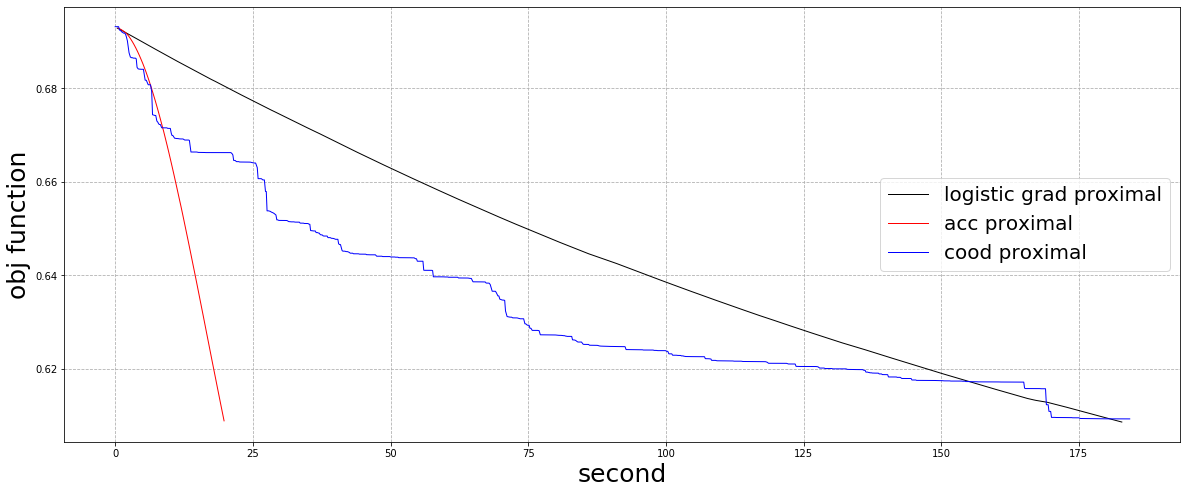

In [764]:
# print(fx_array_method2)
fig = plt.figure(figsize=(20, 8))
plt.plot(time_array,fx_array, label=("logistic grad proximal"), linewidth=1.0, color ="black")
plt.plot(time_array_acc,fx_array_acc, label=("acc proximal"), linewidth=1.0, color ="red")
plt.plot(time_array_cood,fx_array_cood, label=("cood proximal"), linewidth=1.0, color ="blue")
# plt.plot(time_array_acc_cood,fx_array_acc_cood, label=("acc cood proximal"), linewidth=1.0, color ="green")
plt.legend(prop={'size': 20},loc="right")
plt.xlabel("second", fontsize=25)
plt.ylabel("obj function", fontsize=25)
plt.grid(linestyle='dashed')
plt.show()

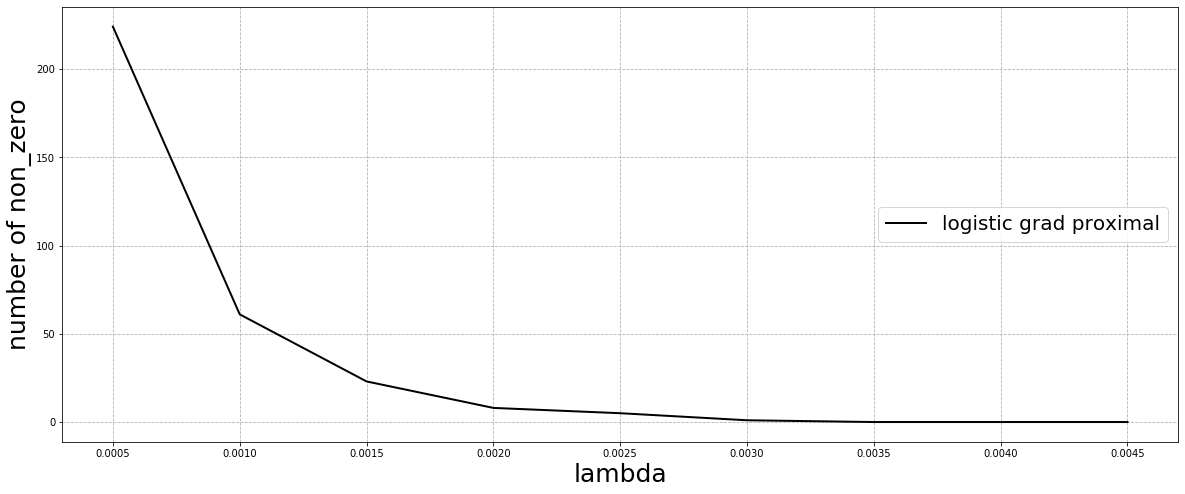

In [11]:
#q2
weight = genWeight_set()
lambda_array = [0.0005,0.001,0.0015,0.002,0.0025,0.003,0.0035,0.004,0.0045]
non_zero_array =[]
for i in range(len(lambda_array)):
    x_result, fx_array, time_array = prox_gradient_descent(weight, lambda_array[i], trainLabel, trainA, epsilon, max_iterations)
    non_zero_array.append(np.count_nonzero(x_result))


fig = plt.figure(figsize=(20, 8))
plt.plot(lambda_array,non_zero_array, label=("logistic grad proximal"), linewidth=2.0, color ="black")
plt.legend(prop={'size': 20},loc="right")
plt.xlabel("lambda", fontsize=25)
plt.ylabel("number of non_zero", fontsize=25)
plt.grid(linestyle='dashed')
plt.show()            

when lambda increases, the number of non-zero features decreases. And it drops to 0 eventually. 

## Label Propagation

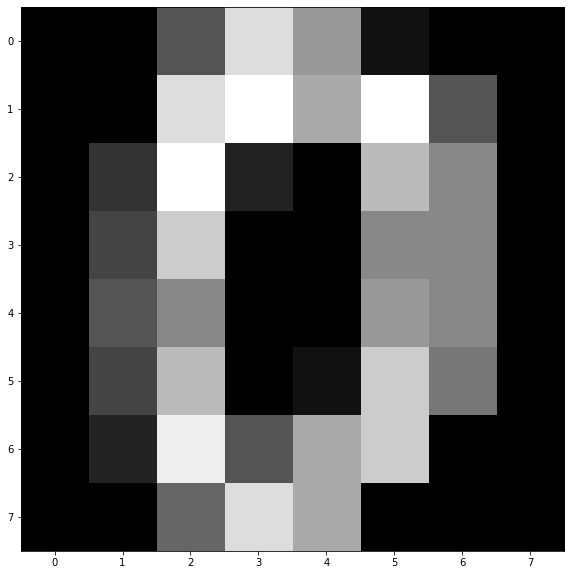

In [4]:
# Load datasets from sklearn
from sklearn import datasets

# Load the digits dataset.
# See here for a distription of this dataset: 
# https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html#sklearn.datasets.load_digits
digits = datasets.load_digits()

# Briefly, this dataset has 1797 images of digits. The digits are from 0 to 9.
# There are about 180 images per digit.

# digits.data includes the vectorized images of the digits
# digits.target includes the labels of the images
# digits.images includes the images in non-vectorized format

# Example: number 0
import matplotlib.pyplot as plt

plt.figure(1, figsize=(10, 10))
plt.imshow(digits.images[0], cmap='gray')
plt.show()


Let x_i and x_j be two vectorized images.
Compute their pairwise similarity by
$$ 
w_{ij} = \exp(-\gamma \|x_i-x_j\|_2^2),
$$
where $\gamma$ is parameter tha controls the importance of the distance $\|x_i-x_j\|_2^2$. If $\gamma=1/(2\sigma^2)$ then this is called the Gaussian kernel and $\sigma^2$ represents the variance.
You can compute the similarities by using: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.rbf_kernel.html.
Alterantively, you can compute the pairwise similarities manually, by using the above formula.

Sparsify the graph by setting small values to zero. The thresholding tolerance is a parameter that you will have to tune. Generally, there is a consensus that sparse similarity matrices result in better performance. So, you should expect that, but have in mind that this is only an empirical observation.

In [5]:
# Example
import sklearn

# Pairwise weights matrix
W = sklearn.metrics.pairwise.rbf_kernel(digits.data)

# Remove self-similarity
import numpy as np
W = W - np.eye(len(W))

# Sparsify (tune the tolerance parameter for your problem)
tol = 1e-16
W[abs(W) < tol] = 0.0

This dataset provides labels for every image of a digit. However, in this assignment we want to check how the label propagation model works. Use all images, i.e., 1797 images of digits, but use only 10 labels per type of digit, e.g., use the first 10 labels for digit 0, the first 10 labels of digit 1 etc. This means that you should use 100 labels in total out of 1797. Do not use the remaining labels for training the model. The remaining labels will be used only to measure accuracy of the model.

Question 3
-------------
Train the label propagation model
$$
\mbox{minimize}_{b\in\mathbb{R}^n} \ \frac{1}{2}\sum_{i=1}^n\sum_{j=1}^n w_{ij} (b_i -b_j)^2 + \sum_{i=1}^{m-n}\sum_{j=1}^n \bar{w}_{ij} (\bar{b}_i -b_j)^2
$$
using the coordinate method that was discussed in Lecture 14 for the label propagation problem. Make sure that you understand the derivation of the algorithm before you apply it to train the label propagation model.

The output of the algorithm should be the soft labels $b$ for each image. However, these soft labels are not going to be integers (actual labels). Therefore, we have to round the output labels $b$ to get integer labels for each image. One possible way to round the output is to simply find the integer label (possible options 0 to 9) that a soft label is closest to. Then pick this label as the label of the image.

After you label all images, use the function in https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html to measure precision, recall and f1_score. You only have to provide the true and the predicted labels when using this function. Do not change the default parameters.

If you want to learn more about precision, recall and f1_score check Wikipedia: 
precision and recall: https://en.wikipedia.org/wiki/Precision_and_recall
f1_score: https://en.wikipedia.org/wiki/F1_score.

Report precision, recall and f1score of your method.

Marks: 20

Question 4
-------------

Increase the number of labels that are used in the model from 10 per digit to 20 per digit. Re-train and report precision, recall and f1score of your method. Explain in a couple of sentences what do you observe.

Marks: 5

In [55]:
num_know_label = 10
true_label_count = [0 for x in range(10)]
true_label_index = []
for i in range(len(digits.target)):
    if sum(true_label_count) >= num_know_label * 10 : break
    if digits.target[i] == 0 and true_label_count[0]<num_know_label:
        true_label_count[0] += 1
        true_label_index.append(i)
    elif digits.target[i] == 1 and true_label_count[1]<num_know_label:
        true_label_count[1] += 1
        true_label_index.append(i)
    elif digits.target[i] == 2 and true_label_count[2]<num_know_label:
        true_label_count[2] += 1
        true_label_index.append(i)
    elif digits.target[i] == 3 and true_label_count[3]<num_know_label:
        true_label_count[3] += 1
        true_label_index.append(i)
    elif digits.target[i] == 4 and true_label_count[4]<num_know_label:
        true_label_count[4] += 1
        true_label_index.append(i)
    elif digits.target[i] == 5 and true_label_count[5]<num_know_label:
        true_label_count[5] += 1
        true_label_index.append(i)
    elif digits.target[i] == 6 and true_label_count[6]<num_know_label:
        true_label_count[6] += 1
        true_label_index.append(i)
    elif digits.target[i] == 7 and true_label_count[7]<num_know_label:
        true_label_count[7] += 1
        true_label_index.append(i)
    elif digits.target[i] == 8 and true_label_count[8]<num_know_label:
        true_label_count[8] += 1
        true_label_index.append(i)
    elif digits.target[i] == 9 and true_label_count[9]<num_know_label:
        true_label_count[9] += 1
        true_label_index.append(i)

print(len(true_label_index))
print(true_label_count)
trueData = []
trueLabel = []
missData = []
missTrueLabel = []
for i in range(len(digits.target)):
    if i in true_label_index:
        trueData.append(digits.data[i])
        trueLabel.append(digits.target[i])
    else:
        missData.append(digits.data[i])
        missTrueLabel.append(digits.target[i])
trueData = np.array(trueData)
trueLabel = np.array(trueLabel)
missData = np.array(missData)
missTrueLabel = np.array(missTrueLabel)
missLabel = np.random.randint(0,10, size=(digits.target.shape[0]-10*num_know_label))
missLabel = missLabel.astype('float64')
W_know_unknow = sklearn.metrics.pairwise.rbf_kernel(missData,trueData)
# remove self-similarity
W_unknow_unknow = sklearn.metrics.pairwise.rbf_kernel(missData)
W_unknow_unknow = W_unknow_unknow - np.eye(len(W_unknow_unknow))

tol = 1e-20
W_unknow_unknow[abs(W_unknow_unknow) < tol] = 0.0
W_know_unknow[abs(W_know_unknow) < tol] = 0.0

100
[10, 10, 10, 10, 10, 10, 10, 10, 10, 10]


(array([20., 20., 20., 20., 20., 20., 20., 20., 20., 20.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

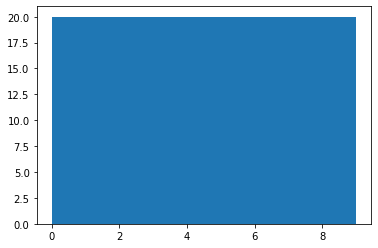

In [52]:
plt.hist(trueLabel)

In [38]:
# def propagation_function(missLabel, w, trueLabel):

def cood_propagation(miss, W_unknow_unknow, trueLabel, W_know_unknow, max_iteration):
    for k in range(max_iteration):
#         print(len(miss))
        for j in range(len(miss)):
            numerator = np.sum(W_unknow_unknow[j] * miss) + np.sum(W_know_unknow[j]*trueLabel)
            denominator = np.sum(W_unknow_unknow[j]) + np.sum(W_know_unknow[j])
            miss[j] = numerator/denominator

    return miss


In [56]:
prediction = cood_propagation(missLabel, W_unknow_unknow, trueLabel, W_know_unknow, 1000)
# print(prediction)
prediction = np.round(prediction)

In [57]:
from sklearn.metrics import precision_recall_fscore_support

precision_recall_fscore_support(missTrueLabel, prediction)

(array([1.        , 0.92156863, 0.88770053, 0.93333333, 0.55183946,
        0.68316832, 0.56856187, 0.51655629, 0.19230769, 0.        ]),
 array([0.99404762, 0.27325581, 0.99401198, 0.7283237 , 0.96491228,
        0.80232558, 0.99415205, 0.92307692, 0.06097561, 0.        ]),
 array([0.99701493, 0.42152466, 0.93785311, 0.81818182, 0.70212766,
        0.73796791, 0.72340426, 0.66242038, 0.09259259, 0.        ]),
 array([168, 172, 167, 173, 171, 172, 171, 169, 164, 170]))

In [58]:
# increase to 20
num_know_label = 20
true_label_count = [0 for x in range(10)]
true_label_index = []
for i in range(len(digits.target)):
    if sum(true_label_count) >= num_know_label * 10 : break
    if digits.target[i] == 0 and true_label_count[0]<num_know_label:
        true_label_count[0] += 1
        true_label_index.append(i)
    elif digits.target[i] == 1 and true_label_count[1]<num_know_label:
        true_label_count[1] += 1
        true_label_index.append(i)
    elif digits.target[i] == 2 and true_label_count[2]<num_know_label:
        true_label_count[2] += 1
        true_label_index.append(i)
    elif digits.target[i] == 3 and true_label_count[3]<num_know_label:
        true_label_count[3] += 1
        true_label_index.append(i)
    elif digits.target[i] == 4 and true_label_count[4]<num_know_label:
        true_label_count[4] += 1
        true_label_index.append(i)
    elif digits.target[i] == 5 and true_label_count[5]<num_know_label:
        true_label_count[5] += 1
        true_label_index.append(i)
    elif digits.target[i] == 6 and true_label_count[6]<num_know_label:
        true_label_count[6] += 1
        true_label_index.append(i)
    elif digits.target[i] == 7 and true_label_count[7]<num_know_label:
        true_label_count[7] += 1
        true_label_index.append(i)
    elif digits.target[i] == 8 and true_label_count[8]<num_know_label:
        true_label_count[8] += 1
        true_label_index.append(i)
    elif digits.target[i] == 9 and true_label_count[9]<num_know_label:
        true_label_count[9] += 1
        true_label_index.append(i)

print(len(true_label_index))
print(true_label_count)
trueData = []
trueLabel = []
missData = []
missTrueLabel = []
for i in range(len(digits.target)):
    if i in true_label_index:
        trueData.append(digits.data[i])
        trueLabel.append(digits.target[i])
    else:
        missData.append(digits.data[i])
        missTrueLabel.append(digits.target[i])
trueData = np.array(trueData)
trueLabel = np.array(trueLabel)
missData = np.array(missData)
missTrueLabel = np.array(missTrueLabel)
missLabel = np.random.randint(0,10, size=(digits.target.shape[0]-10*num_know_label))
missLabel = missLabel.astype('float64')
W_know_unknow = sklearn.metrics.pairwise.rbf_kernel(missData,trueData)
# remove self-similarity
W_unknow_unknow = sklearn.metrics.pairwise.rbf_kernel(missData)
W_unknow_unknow = W_unknow_unknow - np.eye(len(W_unknow_unknow))

tol = 1e-20
W_unknow_unknow[abs(W_unknow_unknow) < tol] = 0.0
W_know_unknow[abs(W_know_unknow) < tol] = 0.0

200
[20, 20, 20, 20, 20, 20, 20, 20, 20, 20]


In [59]:
prediction = cood_propagation(missLabel, W_unknow_unknow, trueLabel, W_know_unknow, 1000)
prediction = np.round(prediction)
precision_recall_fscore_support(missTrueLabel, prediction)

(array([1.        , 0.93181818, 0.57777778, 0.77464789, 0.74879227,
        0.875     , 0.62890625, 0.60305344, 0.21904762, 0.92857143]),
 array([0.99367089, 0.25308642, 0.99363057, 0.67484663, 0.96273292,
        0.60493827, 1.        , 0.99371069, 0.14935065, 0.24375   ]),
 array([0.9968254 , 0.39805825, 0.73067916, 0.72131148, 0.8423913 ,
        0.71532847, 0.77218225, 0.75059382, 0.17760618, 0.38613861]),
 array([158, 162, 157, 163, 161, 162, 161, 159, 154, 160]))

## once I increase the number of labels that are used in the model from 10 per digit to 20 per digit, the performance get better in terms of overall precision recall and fscore. Particularly, the precision, recall and f-score for label 9 is really small when apply 10 per digit, but is much better when apply 20 per digit  

## Local Graph Clustering 

In [60]:
import numpy as np

# Import networkx to load the data
import networkx as nx

# Provide the path of the dataset JohnsHopkins55
path = 'JohnsHopkins55.graphml'

# This dataset is a Facebook anonymized dataset on a particular day in September 2005 
# for a student social network at John Hopkins university. The graph is unweighted 
# and it represents ``friendship'' ties. This graph has 5157 nodes and 186572 edges. 
# This dataset comes along with 6 features, i.e., second major, high school, gender, dorm, major index and year. 
# We construct ``ground truth'' clusters by using the features for each node.
# In particular, we consider nodes with the same value of a feature to be a cluster, e.g., students of year 2009. 
# For this assignment we will attempt to find the students of year 2009 using local graph clustering.

# Load the data as a graph
G = nx.read_graphml(path).to_undirected()

# Construct the adjacency matrix
A = nx.adjacency_matrix(G).astype(np.float64)

# Indices of nodes (students) of class year 2009
# There should be 910 students of class year 2009.
# We will use these students to measure performance of the model
students_of_year_2009 = []
ct = 0
for node in G.nodes(data=True):
    if node[1]['year'] == 2009:
        students_of_year_2009.append(ct)
    ct += 1
print(len(students_of_year_2009))

910


The target cluster is the students of year 2009 in the list: students_of_year_2009.

For this problem you will have to use the coordinate algorithm that was introduced in Lecture 14.

The coordinate algorithm returns a vector $p$. To get an actual cluster from vector $p$ you will have to round the output of the coordinate algorithm using the rounding technique that was discussed in Lecture 14. 

To measure accuracy of the rounded output you can use number of true positives and the number of false positives of the predicted cluster. True positives are the predicted nodes that are also part of class year 2009. False positive are the number of predicted nodes that are not part of the class year 2009.

Question 5
-------------

1) Report the number of nonzero nodes in the output of the coordinate algorithm (vector $p$) as the tolerance parameter $\epsilon$ goes to zero. In particular, plot the number of nonzeros in the output $p$ against $\epsilon$.
The number of nonzeros should increase as $\epsilon$ goes to zero.

Marks: 10

Question 6
-------------

2) Run the coordinate algorithm using as seed node the node with index 5000. Round the output to get an actual cluster back. Measure true positives and false positives of the predicted cluster. Report these two numbers.

Marks: 10

Question 7
-------------

3) Run the coordinate algorithm using as seed node the node with index 146. Round the output to get an actual cluster back. Measure true positives and false positive of the predicted cluster. Report these two numbers. How do they compare to the results in 2) ? Are they different? If yes, why do you think this might have happened? Explain intuitively in a couple of sentences why you think this might happen.

Marks: 5

In [743]:
def compute_p(A, epsilon, alpha, seed_index):
    r = np.zeros(A.shape[0])
    p = np.zeros(A.shape[0])
    d = (A * np.ones((A.shape[0],1))).reshape(A.shape[0],)
    r[seed_index] = 1
    while np.any(r >= (epsilon * d)):
        u = np.where(r >= (epsilon * d))[0][0]
        p[u] = p[u] + alpha * r[u]
        v = A[u].indices
        r[v] = r[v] + 0.5 * (1-alpha) * r[u]/d[u]
        r[u] = (1 - alpha) * r[u]/2 
#         print(str(u) + " :"+ str(r[u]))
    return p

### question 5

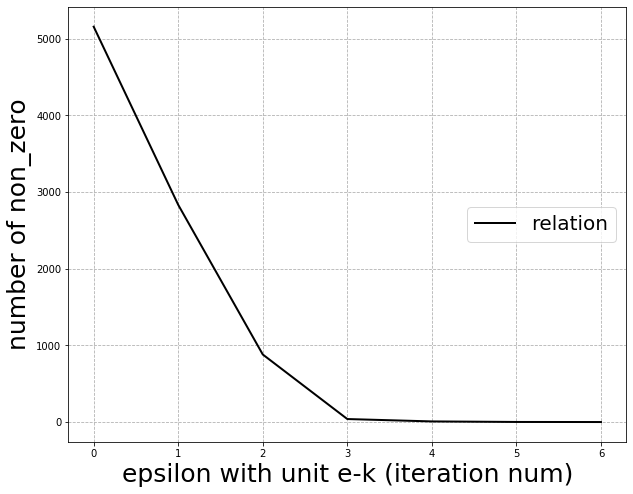

In [765]:
epsilon_list =  [1.0e-7,1.0e-6,1.0e-5,1.0e-4,1.0e-3,1.0e-2,1.0e-1]
num_nonzero = []
alpha = 0.1
seed_index = 5000
for ep in epsilon_list:
    p = compute_p(A,ep,alpha,seed_index)
    num_nonzero.append(np.count_nonzero(p))
fig = plt.figure(figsize=(10, 8))
plt.plot(num_nonzero, label=("relation"), linewidth=2.0, color ="black")
plt.legend(prop={'size': 20},loc="right")
plt.xlabel("epsilon with unit e-k (iteration num)", fontsize=25)
plt.ylabel("number of non_zero", fontsize=25)
plt.grid(linestyle='dashed')
plt.show() 

In [374]:
def conductance(A, p):
    d = np.sum(A,axis = 1)
    result = []
    sortedIndex = np.argsort(p/d,axis  =0)[::-1]
    sort = np.sort(p/d,axis = 0)[::-1]
    
    nodeInCluster = []
    nodeNotInCluster = [i for i in range(5157)]
    sum_degree = 0
    min_index = 0
    min_conductance = 1
    for i in range(len(sort)):
        index = sortedIndex[i,0]
        if p[index] == 0: break
        nodeInCluster.append(index)
        nodeNotInCluster.remove(index)
        allEdge = A[nodeInCluster].T
        edge_leaving = np.sum(allEdge[nodeNotInCluster])

        sum_degree += d[index]
        conductance = edge_leaving/sum_degree
#         print("iteration: "+ str(i)+ "  "+str(conductance)+ " min_cond "+str(min_conductance))
        if (conductance < min_conductance):
            min_conductance = conductance
            min_index = i
    nodeInCluster = sortedIndex[:min_index+1]
    return nodeInCluster

In [389]:
epsilon = 1.0e-6
alpha = 0.1
seed_index = 5000
p = compute_p(A,epsilon,alpha,seed_index)
print(np.count_nonzero(p))
p = np.reshape(p,(len(p),1))
result = conductance(A, p)

2833


### question 6

In [387]:
def measure(students_of_year_2009,result):
    h=result.flatten().tolist()
    h = h[0]
    set_students_of_year_2009 = set(students_of_year_2009)
    set_prediction = set(h)
    true_positive = len(set_students_of_year_2009.intersection(set_prediction))
    false_positive = len(set_prediction) - true_positive
    return true_positive,false_positive

In [388]:
true_positive,false_positive = measure(students_of_year_2009,result)
print("true positive "+str(true_positive) +" false_positive "+str(false_positive))

true positive 852 false_positive 84


### question 7

In [391]:
epsilon = 1.0e-6
alpha = 0.1
seed_index = 146
p = compute_p(A,epsilon,alpha,seed_index)
print(len(p))
p = np.reshape(p,(len(p),1))
result = conductance(A, p)
true_positive,false_positive = measure(students_of_year_2009,result)
print("true positive "+str(true_positive) +" false_positive "+str(false_positive))

5157
true positive 900 false_positive 2720


### The true positive is about the same, but false positive is really big. I think that may happen because this student is very social so that he has connection with too many students that are not in year 2009


## Reccomender System

Download the data matrix $A$ from the webiste https://grouplens.org. Navigate to the dataset tab https://grouplens.org/datasets/movielens/ and download the dataset MovieLens 100K. Read the description of the dataset carefully. 
This dataset includes 5 data matrices $A$. We only need to use one of these in this assignment. In particular, use the dataset u1.base. Use the corresponding testing data u1.test to measure the accuracy of your model. For this question only it's ok if you use the testing data to tune parameters. Ignore the timestap feature in the dataset. We do not need this for this problem.

Question 8
------------

Solve the penalized problem
$$
\mbox{minimize} \ \lambda \|X\|_* + \sum_{ij \ | \ A_{ij} \ is \ known} (X_{ij} - A_{ij})^2,
$$
where $\|X\|_*$ is the nuclear norm, using proximal gradient descent. This algorithm requires thresholding the singular values of $X$ at each iteration.
You can use https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.svd.html (sparse matrices) or https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.svd.html (dense matrices).

To check your solution against u1.test, report your score as follows. Let $X$ be the output of the proximal gradient method, let $A'$ and $\Omega'$ be the data matrix and the non-zero entry list for the test data. Then the score is 
$$
\frac{1}{|\Omega'|} \sum_{(i,j)\in\Omega'} | X_{ij} - A_{ij}'|.
$$
In other words, the average absolute deviation of the computed ratings from the predicted ratings. Report your score.

Marks: 15

Question 9
------------

Now consider the factorized problem
$$
\mbox{minimize}_{L,R} \ \frac{\lambda}{2} \left(\|L\|_F^2 + \|R\|_F^2\right) + \|W\circ (LR^T-A)\|_F^2
$$
See Lecture 15 about details for this problem. Solve this problem and obtain the matrix $X=LR^T$. Use $X$ as the predicted rating and report your score. For calculating derivatives of matrix functions you can have a look here: https://www.math.uwaterloo.ca/~hwolkowi/matrixcookbook.pdf. 

Marks: 10

In [748]:
from scipy import linalg
def gradient_fx_rec(x,A):
    indices = np.where(A == 0)
    result = 2*(x-A)
    result[indices] = 0
    result = np.array(result)
    return result

def proximal_rec(x, alpha, lambda_):
    U, s, Vh = linalg.svd(x)
    condition = alpha*lambda_
    prox = np.where(s >=condition, s - condition, 0)
    result = np.zeros([len(s),Vh.shape[0]])
    np.fill_diagonal(result,prox)
    result = (U.dot(result)).dot(Vh)
    return result

def fx_rec(x,A):
    indices = np.nonzero(A)
    result = np.sum(np.square(x[indices]-A[indices]))
    return result

def gx_rec(x,lambda_):
    u, s, v = np.linalg.svd(x, full_matrices=True)
    sing = np.array(s)
    return lambda_*np.sum(s)

def armijo_line_search_rec(xk, lambda_, a):
    alpha = 1
    theta = 0.5
    fxk = fx_rec(xk, a)
    F_xk = fxk + gx_rec(xk,lambda_)
    l_xk = F_xk
    grad_fx = gradient_fx_rec(xk,a)
    iteration = 1
    while True:
        update = xk - alpha * grad_fx
        
        x_alpha = proximal_rec(update, alpha, lambda_)
        gx = gx_rec(x_alpha,lambda_)
        F_xalpha = fx_rec(x_alpha, a) + gx
        l_xalpha = gx + fxk + np.sum((grad_fx)*(x_alpha - xk))
        if F_xalpha <= F_xk - theta*(l_xk - l_xalpha):break
        alpha = alpha/2
        iteration += 1
    return x_alpha,F_xalpha, alpha

def prox_gradient_descent_rec(x, lambda_, a, epsilon, max_iterations):
    iteration = 1
    fx_array = []
    start_time = time.time()
    time_array = []
#     alpha = 0.1
    while True:
#         grad_fx = gradient_fx_rec(x,a)
        x_alpha,F_xalpha, alpha = armijo_line_search_rec(x, lambda_, a)
#         update = x - alpha * grad_fx
#         x_alpha = proximal_rec(update, alpha, lambda_)
        G_x = (1/alpha) * (x - x_alpha)
#         F_xalpha = fx_rec(x_alpha, a) + gx_rec(x_alpha,lambda_)
        fx_array.append(F_xalpha)
        time_array.append(time.time() - start_time)
        x = x_alpha
        if norm(G_x,2) <= epsilon or iteration >= max_iterations: break
        iteration += 1
    return x,fx_array,time_array

def compute_score(test_a, weight):
    
    size = np.count_nonzero(test_a)
    indices = np.nonzero(test_a)

    error = np.sum(np.abs(weight[indices]-test_a[indices]))
    result = error/size
    return result

In [517]:
import re 

a = np.zeros([943, 1682])
with open('u1.base') as my_file:
    max_u = 0
    for line in my_file:

        line = re.findall(r"[\w']+", line)
        
        u = int(line[0])
        i = int(line[1])
        r = int(line[2])
        
        a[u-1][i-1] = r    
# a=sparse.csr_matrix(a)       

def genWeight_rec(a):
#     weights = np.ones([a.shape[0],a.shape[1]])
    weights =np.random.randint(1,6, size=([a.shape[0],a.shape[1]]))
#     weights = np.random.normal(0.0,1.0,[train_data_news.shape[1],1])/train_data_news.shape[1]
#     weights = np.random.normal(0.0,1.0,[train_data_news.shape[1],1])
    return weights

In [749]:
lambda_=2
max_iterations = 100
epsilon = 1.0e-4
weight = genWeight_rec(a)
x_alpha_rec, fx_array_rec, time_array_rec = prox_gradient_descent_rec(weight, lambda_, a, epsilon, max_iterations)


In [750]:
test_a = np.zeros([462, 1591])
with open('u1.test') as my_file:
    max_u = 0
    for line in my_file:

        line = re.findall(r"[\w']+", line)
        
        u = int(line[0])
        i = int(line[1])
        r = int(line[2])
        test_a[u-1][i-1] = r

# print(np.count_nonzero(test_a))
# print(np.count_nonzero(x_alpha_rec))
score = compute_score(test_a, x_alpha_rec)
print(score)

0.7733564937560478


In [751]:
def grad_R(W, L, R, A, lambda_):
    return lambda_*R + 2*((W * (L.dot(R.T) - A)).T).dot(L)

def grad_L(W, L, R, A, lambda_):
    return lambda_*L + 2*(W * (L.dot(R.T) - A)).dot(R)

def f_LR(W, L, R, A, lambda_):
    term2 = W * (L.dot(R.T) - A)
    return (lambda_/2)*(np.trace(L.dot(L.T)) + np.trace(R.dot(R.T))) + np.trace(term2.dot(term2.T))

def alter_min(x, A, lambda_, max_iteration):
    W = np.zeros(A.shape)
    nonzero_indices = np.nonzero(A)
    W[nonzero_indices] = 1
    L,RT = np.linalg.qr(x)
    fx_array = []
    R = RT.T
    iteration = 0
    alpha = 0.0001
    while iteration< max_iteration:
        R = R - alpha * grad_R(W, L, R, A, lambda_)
        L = L - alpha * grad_L(W, L, R, A, lambda_)
        iteration += 1
        fx_array.append(f_LR(W, L, R, A, lambda_))
    return L, R

In [760]:
weight =np.zeros(a.shape)
lambda_ = 1
L,R = alter_min(weight, a, lambda_, 500)


In [761]:
x = L.dot(R.T)
score2 = compute_score(test_a, x)
print(score2)

0.7411423689648855


## Nonnegative Matrix Factorization: facial feature extraction

Dataset consists of 400 faces


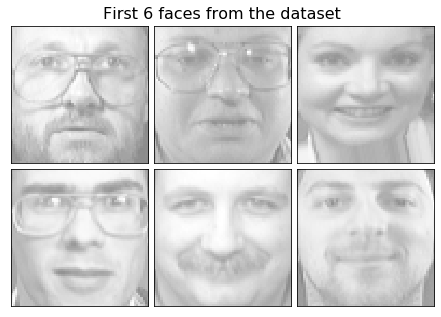

In [544]:
# This piece of code is for loading data and visualizing 
# the first 6 images in the dataset.

# Useful packages for loading the data and plotting
from numpy.random import RandomState
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_olivetti_faces

n_row, n_col = 2, 3
image_shape = (64, 64)
rng = RandomState(0)

# Useful function for plotting
def plot_gallery(title, images, n_col=n_col, n_row=n_row, cmap=plt.cm.gray):
    plt.figure(figsize=(2. * n_col, 2.26 * n_row))
    plt.suptitle(title, size=16)
    for i, comp in enumerate(images):
        plt.subplot(n_row, n_col, i + 1)
        vmax = max(comp.max(), -comp.min())
        plt.imshow(comp.reshape(image_shape), cmap=cmap,
                   interpolation='nearest',
                   vmin=-vmax, vmax=vmax)
        plt.xticks(())
        plt.yticks(())
    plt.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)

# Load faces data
dataset = fetch_olivetti_faces(shuffle=True, random_state=rng)

# Store the vectorized images. Each image has dimensions 64 x 64.
faces = dataset.data
n_samples = faces.shape[0]
print("Dataset consists of %d faces" % n_samples)
    
plot_gallery("First 6 faces from the dataset", faces[:6])    

Question 10
--------------

Use the data in "faces" from the above code for the nonnegative matrix factorization problem 
\begin{align*}
\mbox{minimize}_{W,H} &  \ F(W,H):= \frac{1}{2}\| WH-X\|_F^2\\
\mbox{subj. to} & \ W_{ij}\ge 0 \ \forall i,j \\
                &  \ H_{ij}\ge 0 \ \forall i,j
\end{align*}
where $W\in\mathbb{R}^{m\times r}$ and $H\in\mathbb{R}^{r\times n}$.
Set parameter $r=6$ in the nonnegative factorization problem. Extract the features matrix $W$ by solving the non-negative matrix factorization problem. Report the 6 features of the faces dataset, i.e., the 6 columns of matrix $W$. You can report the features by visualizing them in a similar way to the above example.

Marks: 15

Question 11
--------------

Visualize the approximation of the first 6 images using the feature matrix $W$ and the importance matrix $H$. Note that each face can be approaximated by a linear combination of features (columns) from matrix $W$. The positive coefficients of this linear combination are given by matrix $H$.

Marks: 5

Question 12
--------------

Use matrix $H$ to find the 3 most important features of the first 6 faces. To find the 3 most important features for an image pick the columns of $W$ with the largest coefficients in matrix $H$.

Marks: 5

In [762]:
def grad_H(W, H, X):
    return W.T.dot(W.dot(H) - X)

def grad_W(W, H, X):
    return (W.dot(H) - X).dot(H.T)

def obj_HW(W, H, X):
    obj = W.dot(H) - X
    return (1/2)*np.trace(obj.dot(obj.T))

def WH_bar(WH, sigma, gradient_WH):
    max_WH = np.where(WH > sigma, WH, sigma)
    WH = np.where(gradient_WH >= 0, WH, max_WH)
    return WH

def face_extract(x, sigma, yita, max_iteration):
    W = np.random.random([x.shape[0], 6])
    S = np.diag(1/(W.sum(axis = 0)))
    S_inv = np.diag(W.sum(axis = 0))
    H = np.random.random([6, x.shape[1]])
    yita_W = yita * np.ones(W.shape)
    yita_H = yita * np.ones(H.shape)
    iteration = 0
    while iteration < max_iteration:
        gradient_H = grad_H(W, H, x)
        gradient_W = grad_W(W, H, x)
        
        H_bar = WH_bar(H, sigma, gradient_H)
        W_bar = WH_bar(W, sigma, gradient_W)
        
        denominator_H = (W.T.dot(W)).dot(H_bar) + yita_H
        H_new = H - np.divide(H_bar, denominator_H) * gradient_H
        
        gradient_W_new = grad_W(W, H_new, x)
        denominator_W = W_bar.dot(H.dot(H.T)) + yita_W
        W_new = W - np.divide(W_bar, denominator_W)*gradient_W_new
        
        S = np.diag(1/W.sum(axis = 0))
        S_inv = np.diag(W.sum(axis = 0))
        
        W = W_new.dot(S)
        H = S_inv.dot(H_new)
        
        iteration += 1
    return W,H


In [763]:
train_x = faces.T
print(train_x.shape)
w_opt, h_opt = face_extract(train_x, 0.5, 0.5, 500)

(4096, 400)


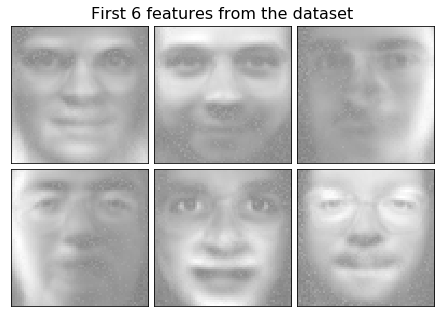

In [757]:
n_row, n_col = 2, 3
image_shape = (64, 64)
rng = RandomState(0)

plot_gallery("First 6 features from the dataset", w_opt.T[:6]) 

### question 11

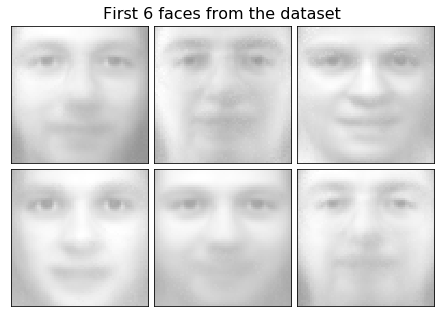

In [758]:
result = w_opt.dot(h_opt)
plot_gallery("First 6 faces from the dataset", result.T[:6]) 

### question 12

In [769]:
for i in range(6):
    h_six = h_opt[:,i]
    # h_sum = np.sum(h_six,axis=1)
    sorted_h_index = np.argsort(h_six,axis  =0)[::-1]
    print(sorted_h_index[:3])
#     plot_gallery("3 most important features from the dataset", w_opt.T[sorted_h_index[:3]]) 


[3 2 1]
[2 4 0]
[4 3 5]
[0 1 4]
[3 1 5]
[2 5 0]
